In [25]:
%matplotlib inline
import re
import sys
import os
from datetime import datetime
import numpy as np
from mpmath import mp
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import math
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = [24.0, 16.0]
plt.rcParams['text.latex.unicode'] = False
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'DejaVu Sans'
print(f'Current directory {os.getcwd()}')

Current directory /Users/remco/0x/OpenZKP/crypto/stark-verifier-ethereum


In [26]:
NUM_TEST = 20

In [27]:
def events(log):
    EVENT_COST = 1954
    start = None
    discount = 0
    events = []
    for line in log.split('\n'):
        match = re.search(r'^(ENTER|LEAVE) (\w+) (\d+) (\d+)$', line)
        if match:
            (event, name, gas, mem) = match.groups()
            gas = -int(gas)
            mem = int(mem)
            if start:
                gas -= start
            else:
                start = gas
                gas = 0
            begin = event == 'ENTER'
            if not name in ['calldata', 'transaction']:
                discount += EVENT_COST
            gas -= discount
            events += [(gas, begin, name, mem)]
    return events

In [62]:
def process(events):
    stack = []
    spans = []
    alloc = []
    histogram = {}
    last = None
    for event in events:
        (time, begin, name, mem) = event
        # Collect top of stack histogram
        if not last is None:
            top_of_stack = stack[-1][2]
            duration = time - last
            if top_of_stack in histogram:
                histogram[top_of_stack] += duration
            else:
                histogram[top_of_stack] = duration
        last = time
        # Compute spans
        if begin:
            stack += [event]
        else:
            (start, _, previous_name, _) = stack[-1]
            stack = stack[:-1]
            assert name == previous_name
            spans += [(len(stack), start, time, name)]
        # Compute memory allocation
        alloc += [[time, mem]]
    histogram = {k: v for k, v in sorted(histogram.items(), key=lambda item: -item[1])}
    # print(len(spans), len(histogram))
    return spans, histogram, alloc

In [63]:
def flamegraph(spans):
    labels = list(set([span[3] for span in spans]))
    maxt = spans[-1][2]
    colour_map = mpl.cm.rainbow(np.linspace(0, 1, len(labels)))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim((0,maxt))
    ax.set_ylim((0,7))

    for span in spans:
        (depth, start, end, label) = span
        colour = colour_map[labels.index(label)]
        rectangle = mpl.patches.Rectangle((start, depth), end - start, 1, fc=colour, ec='white')
        ax.add_patch(rectangle)
        if end - start > 0.05 * maxt:
            ax.text(start + 0.005 * maxt, depth+0.05, label)
        elif end - start > 0.01 * maxt:
            ax.text(start + 0.005 * maxt, depth+0.05, label, rotation='vertical', verticalalignment='bottom')

In [64]:
data = [process(events(open(f'gas-{i}.log').read())) for i in range(NUM_TEST)]

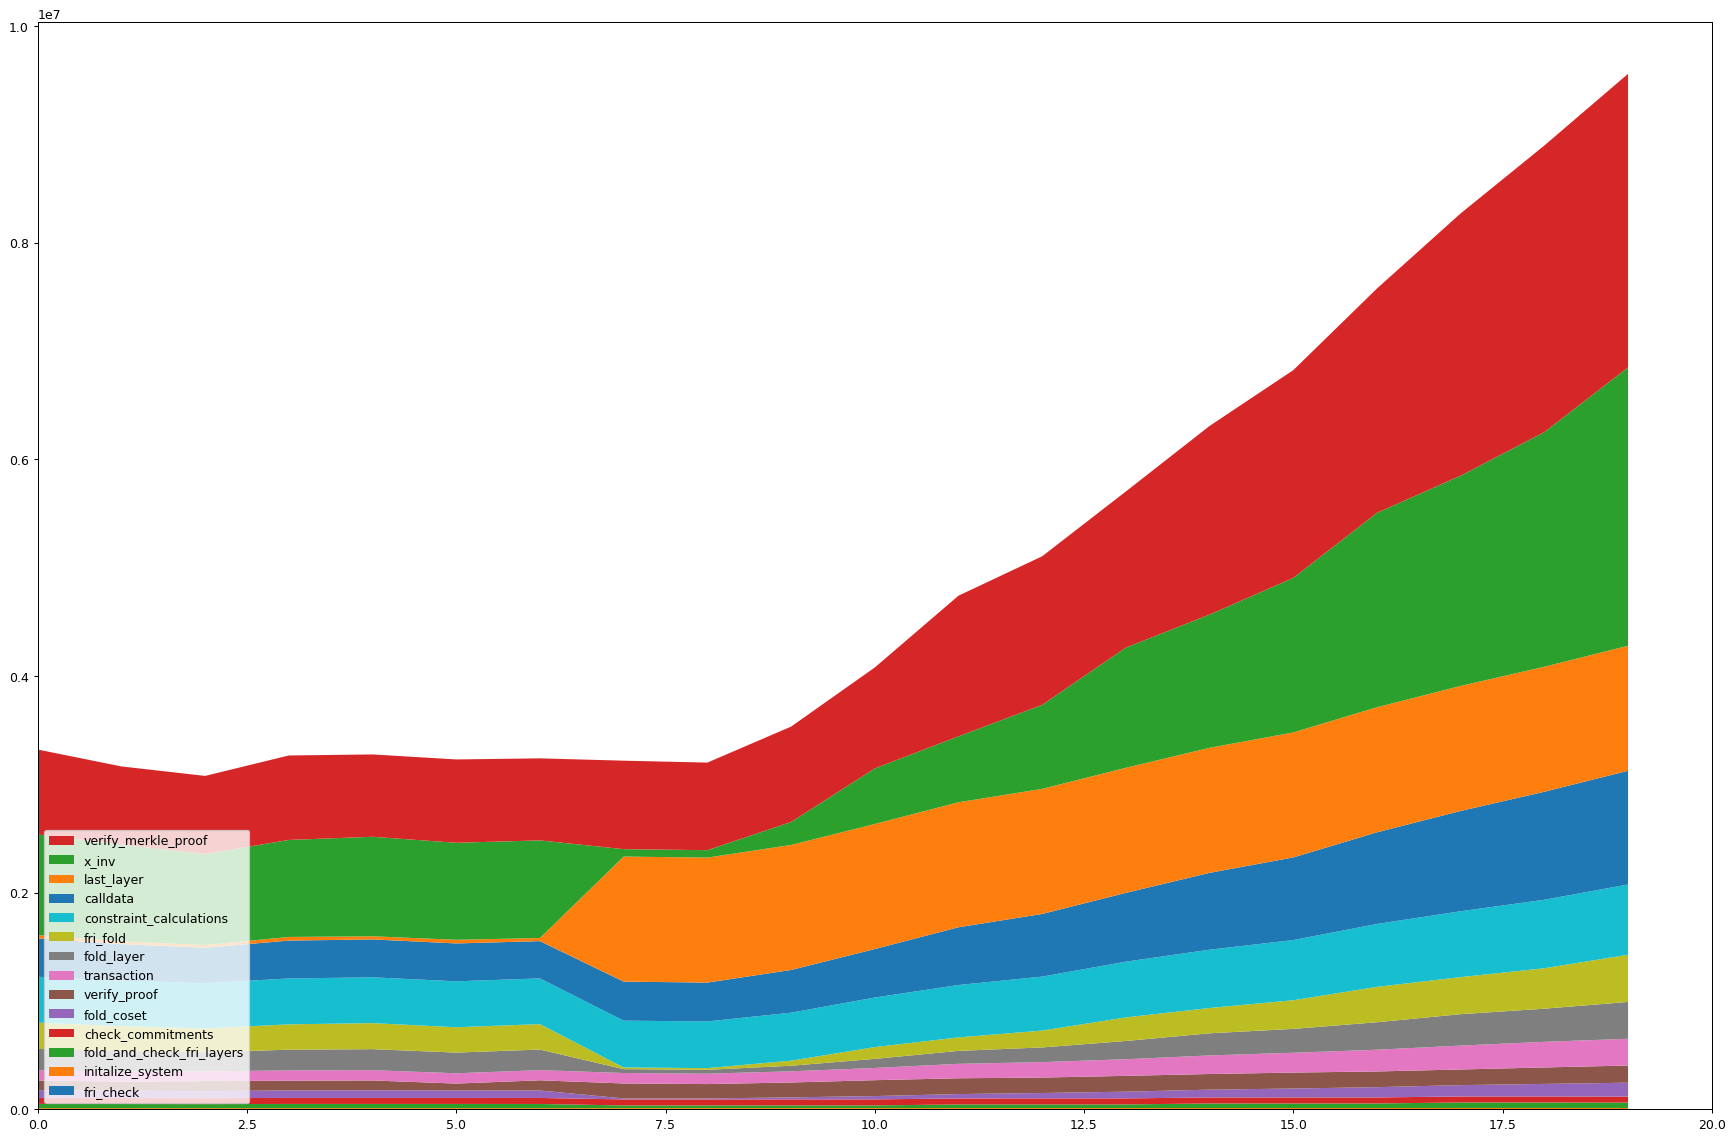

In [66]:
labels = list(data[-1][1].keys())
values = np.array([[hist[label] for label in labels] for (_, hist, _) in data]).T
fig, ax = plt.subplots()
x = range(NUM_TEST)
y = values # / np.sum(values, axis=0)
ax.stackplot(x, y[::-1, :], labels=labels[::-1])
ax.set_xlim((0,NUM_TEST))
#ax.set_ylim((0,1))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left')

plt.show()

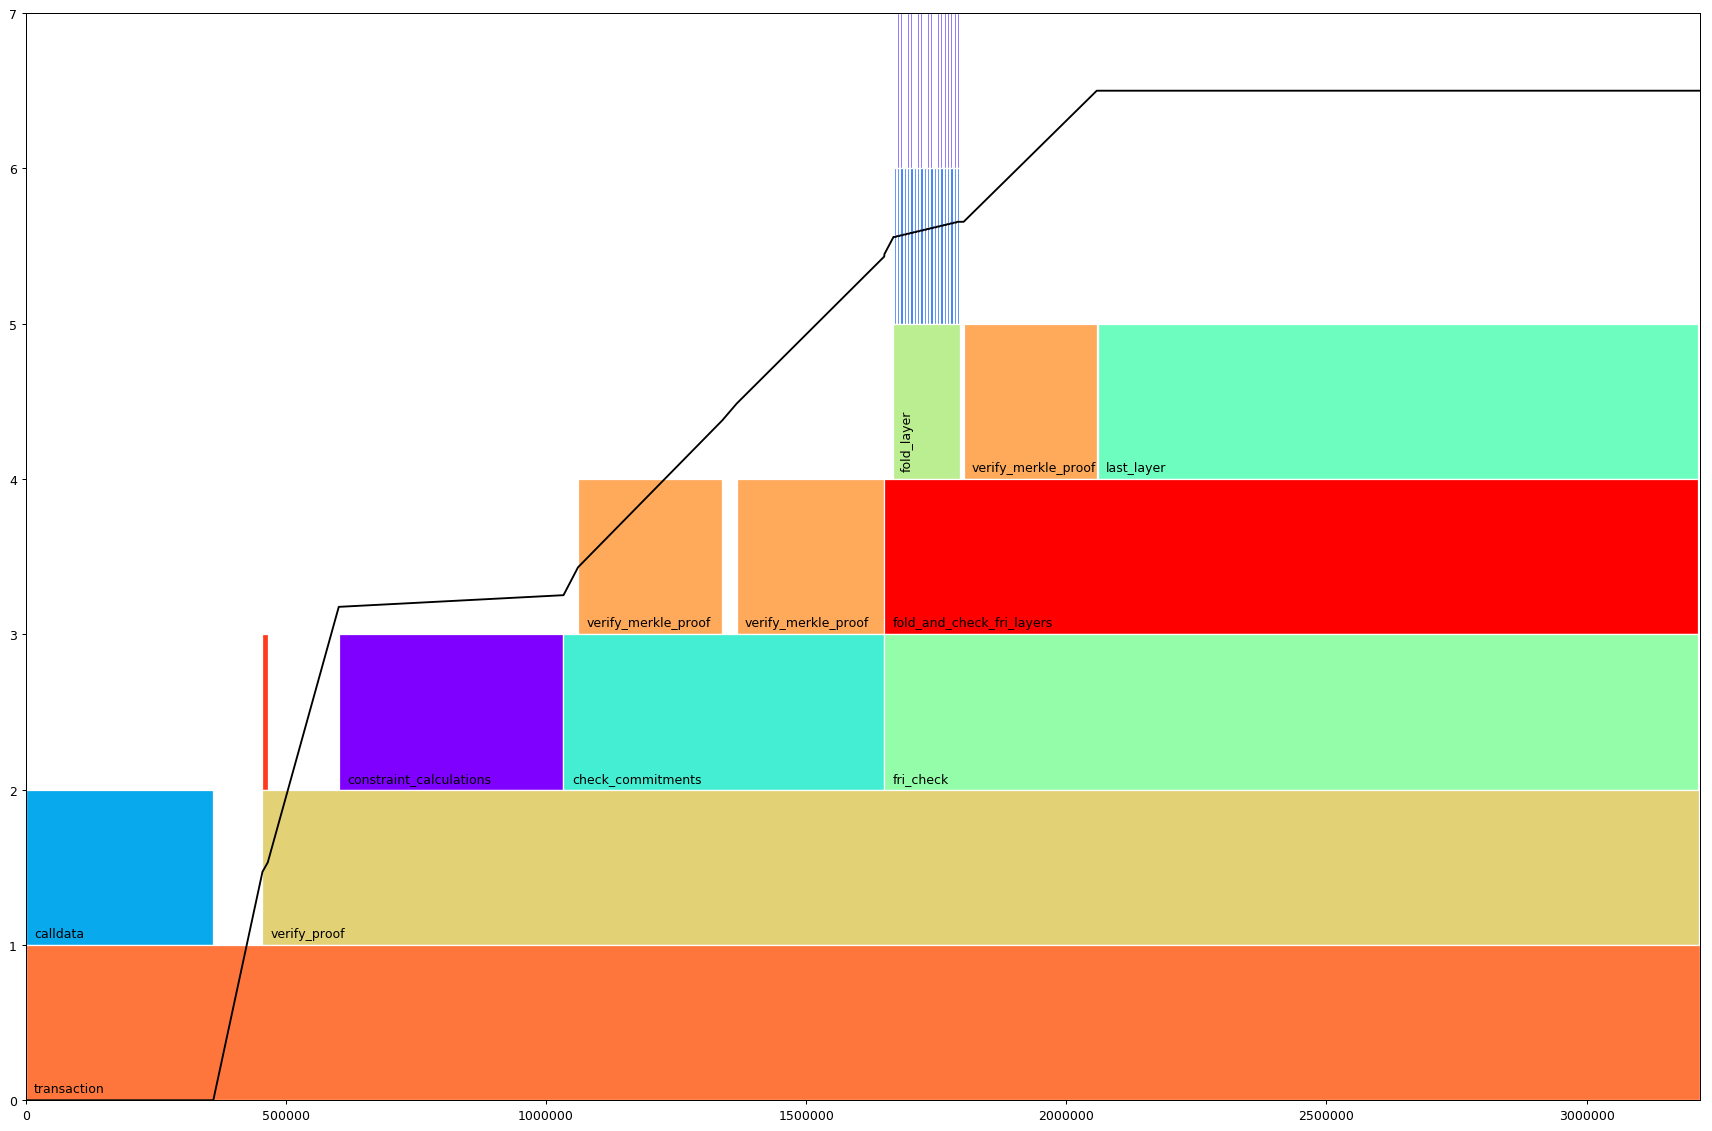

In [68]:
INDEX = 7 # <-- change to view a different run

flame, _, alloc = data[INDEX]
alloc = np.array(alloc)
flamegraph(flame)
plt.plot(alloc[:, 0], 6.5 * alloc[:, 1] / max(alloc[:, 1]), color='black')